# 2.3 Monte Carlo algorithms: HyperLogLog
### 2.3.2 Implement following algorithms for cardinality estimation:
1. Trivial counting using hashmap
2. Flajolet-Martin algorithm
3. LogLog algorithm
4. SuperLogLog algorithm
5. HyperLogLog algorithm

In [11]:
import hashlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

PHI = 0.77351

#### 2.3.2.1 Trivial counting using hashmap
Here we'll use incomplete hashmap to count distinct elements

In [2]:
def count_trivial(data):
    counts = {}
    for item in data:
        if item in counts:
            counts[item] += 1
        else:
            counts[item] = 1

    unique = len(counts)

    return unique

However, the more "pythonic" way to do this is to take a length of the set. This method is more terse, but very similar and yields the same result:

In [3]:
def count_trivial_set(data):
    return len(set(data))

However, these methods can be very inefficient on huge amounts of data because all keys are stored in a hashmap. It requires a lot of memory, which may not even be enough.

Therefore, now we will move on to the implementation of Flajolet-Martin algorithm, which allows us to perform this task using less memory.

#### 2.3.2.2 Flajolet-Martin algorithm

In [4]:
def count_trailing_zeros(x):
    count = (x & -x).bit_length() - 1

    return count

In [5]:
def count_flajolet_martin(data):
    longest_run = 0

    for item in data:
        hash_value = int(hashlib.sha1(item).hexdigest(), 16)
        longest_run = max(longest_run, count_trailing_zeros(hash_value))

    cardinality = 2 ** longest_run / PHI

    return cardinality

This algorithm was inspired by post on [towardsdatascience.com](https://towardsdatascience.com/hyperloglog-a-simple-but-powerful-algorithm-for-data-scientists-aed50fe47869) given to us as resources for this practical task. However, this algorithm seemed a bit incorrect to me, so I started digging around and came across the original paper [Probabilistic Counting Algorithms for Database Applications (1985)](http://algo.inria.fr/flajolet/Publications/FlMa85.pdf).

On page number 4 we can see that this algorithm is described differently. Instead of searching for the longest run of zeros, they use BITMAP, and write 1 to the indices in the BITMAP corresponding to the number of trailing zeros found in the hash value.
Let $R$ be the position of the leftmost zero in BITMAP. The expected value of $R$ is close to: $$E(R) \approx log_2{\ \phi n}$$
Therefore, we can define cardinality as $\frac{2^R}{\phi}$.

So, let's implement the "right" version of this algorithm:

In [6]:
def count_flajolet_martin_enhanced(data):
    bitmap = np.zeros(hashlib.sha1().digest_size * 8, dtype=int)

    for item in data:
        hash_value = int(hashlib.sha1(item).hexdigest(), 16)
        bitmap[count_trailing_zeros(hash_value)] = 1

    leftmost_zero = np.argmax(bitmap == 0)

    cardinality = 2 ** leftmost_zero / PHI

    return cardinality

#### 2.3.2.3 LogLog algorithm

LogLog algorithm is pretty much similar to the previous one. The only difference is that LogLog uses buckets instead of bitmap to simulate multimple hash-functions. Number of buckets is 2^k, where k is a parameter that determines the accuracy of the algorithm.

The hash value is split into two parts: the first part is used to determine the bucket index and consists of first k bits of the value, and the second part is used to determine the number of leading zeros in the hash value. Let's implement this algorithm as well. I have run several tests and chose the optimal $k$ for the next algorithms.

In [7]:
def count_loglog(data, k=6):
    m = 1 << k
    buckets = np.zeros(m, dtype=int)

    for item in data:
        hash_value = int(hashlib.sha1(item).hexdigest(), 16)
        bucket = hash_value & (m - 1)

        bucket_value = count_trailing_zeros(hash_value >> k)
        buckets[bucket] = max(buckets[bucket], bucket_value)

    average = np.mean(buckets)

    cardinality = m * (2 ** average / PHI)

    return cardinality

However, this algorithm can still be improved.

#### 2.3.2.4 SuperLogLog algorithm

SuperLogLog algorithm is a modification of the LogLog algorithm. It uses a different way to calculate the average. Instead of calculating the average of all buckets, it calculates the average of the smallest 70% of buckets.

As Flajolet stated, this modification improves the accuracy of the algorithm from $\frac{1.3}{\sqrt m}$ to $\frac{1.05}{\sqrt m}$ where m is number of objects in data:

In [8]:
def count_super_loglog(data, k=8):
    m = 1 << k
    buckets = np.zeros(m, dtype=int)

    for item in data:
        hash_value = int(hashlib.sha1(item).hexdigest(), 16)
        bucket = hash_value & (m - 1)

        bucket_value = count_trailing_zeros(hash_value >> k)
        buckets[bucket] = max(buckets[bucket], bucket_value)

    buckets = np.sort(buckets)[:int(0.7 * m)]

    average = np.mean(buckets)
    cardinality = m * (2 ** average / PHI)

    return cardinality

#### 2.3.2.5 HyperLogLog algorithm

Here we go to the last algorithm of this type - HyperLogLog. In fact, the original algorithm is quite difficult to calculate and understand, but it is well described in the original paper: [HyperLogLog: the analysis of a near-optimal cardinality estimation algorithm](http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf).

Since in this practical we evaluate some works of this algorithm on Poisson distributions with $\lambda$ equal to 1000, we can count on the fact that the number of distinct elements $n$ will be significantly less than the number of buckets $m$.

Indeed, When $n < \frac{5}{2} m$, non-linear distortions begin to appear - on the extreme side, a raw algorithm with registers initialized to 0 will always return a cardinality value that is too high. Because of this, we have to introduce a modification to this algorithm and calculate the result a bit differently.

According to original paper, the number of empty buckets is about $me^{-\mu}$, where $\mu$ is equal to $n/m$. Thus, upon observing $v$ empty buckets amongst a total of $m$, we may legitimately expect $\mu$ to be close to $log(m/v)$. Therefore, $n$ must be close to $m\ log(m/v)$

Also, I will calculate the optimal $k$ value for required error_rate by taking $\left\lceil{{log_2{\frac{1.04}{err\_rate}}^2}}\right\rceil$

In [9]:
def count_hyper_loglog(data, error_rate=0.01):
    k = int(np.ceil(np.log2((1.04 / error_rate) ** 2)))
    buckets_count = 1 << k
    buckets = np.zeros(buckets_count, dtype=int)

    for item in data:
        hash_value = int(hashlib.sha1(item).hexdigest(), 16)

        bucket_index = hash_value & (buckets_count - 1)
        bucket_value = count_trailing_zeros(hash_value >> k) + 1

        buckets[bucket_index] = bucket_value

    zero_buckets = np.count_nonzero(buckets == 0)

    cardinality = np.floor(buckets_count * np.log(buckets_count / zero_buckets))

    return cardinality

As you might have noticed, in this algorithm we don't care about actual number of trailing zeros, so we'll just "flag" the filled buckets by setting 1 on them.

### 2.3.3 Generate input data

Poisson distribution with $\lambda$ equal to 1000

In [23]:
def poisson_distribution(size):
    return np.random.poisson(1000, size=size)

Sample sizes $N = 1k,\ 10k,\ 100k,\ 1M,\ 10M$

In [24]:
sizes = np.array([10 ** i for i in range(3, 8)])

Let's move on to the next step and analyze these algorithms on generated data

### 2.3.4 Test your algorithms on generated data and analyze following features:
1. Execution time
2. Output error
3. Space complexity

#### 2.3.4.1 Execution time

For measuring execution time, first let's modify out timeit function from previous file a little:

In [25]:
def timeit(func, data):
    import timeit
    return timeit.timeit(lambda: func(data), number=1)

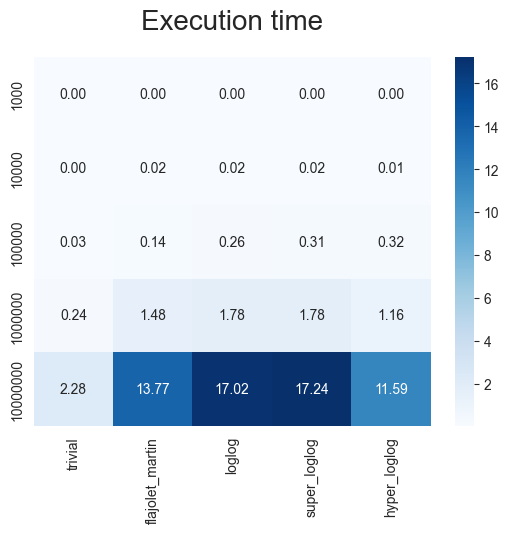

In [26]:
execution_times = pd.DataFrame(columns=['trivial', 'flajolet_martin', 'loglog', 'super_loglog', 'hyper_loglog'])

for size in sizes:
    poisson = np.random.poisson(1000, size=size)
    execution_times.loc[size] = [
        timeit(count_trivial, poisson),
        timeit(count_flajolet_martin, poisson),
        timeit(count_loglog, poisson),
        timeit(count_super_loglog, poisson),
        timeit(count_hyper_loglog, poisson),
    ]

plt.title("Execution time", fontsize=20, pad=20)
sns.heatmap(execution_times, annot=True, fmt='.2f', cmap='Blues')
plt.show()

As we can see, the trivial algorithm is the fastest one. However, it uses a lot of memory which I will show later.

#### 2.3.4.2 Output error

To analyze output error I will use the same strategy as for time measurements and present the values in the heatmap format

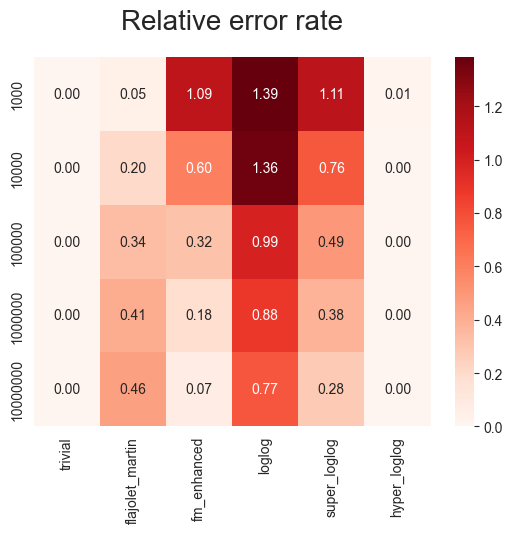

In [27]:
error_rates = pd.DataFrame(columns=['trivial', 'flajolet_martin', 'fm_enhanced', 'loglog', 'super_loglog', 'hyper_loglog'])

for size in sizes:
    poisson = np.random.poisson(1000, size=size)
    actual_cardinality = len(np.unique(poisson))

    error_rates.loc[size] = [
        np.abs(count_trivial(poisson) - actual_cardinality) / actual_cardinality,
        np.abs(count_flajolet_martin(poisson) - actual_cardinality) / actual_cardinality,
        np.abs(count_flajolet_martin_enhanced(poisson) - actual_cardinality) / actual_cardinality,
        np.abs(count_loglog(poisson) - actual_cardinality) / actual_cardinality,
        np.abs(count_super_loglog(poisson) - actual_cardinality) / actual_cardinality,
        np.abs(count_hyper_loglog(poisson) - actual_cardinality) / actual_cardinality,
    ]

plt.title("Relative error rate", fontsize=20, pad=20)
sns.heatmap(error_rates, annot=True, fmt='.2f', cmap='Reds')
plt.show()

Alternatively, we can show the distribution of errors using violin plots. They can be more representative and easy to understand:

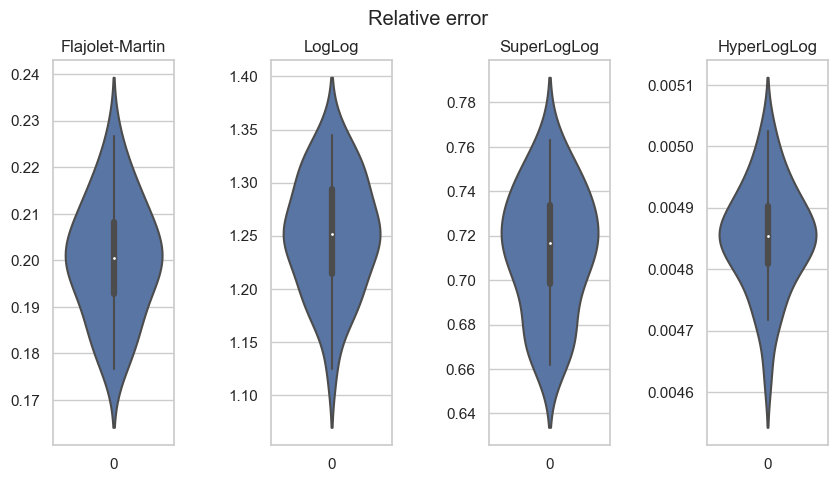

In [14]:
def calculate_errors(func, samples=30):
    errors = []

    for _ in range(samples):
        poisson = np.random.poisson(1000, 10000)

        real_cardinality = count_trivial(poisson)
        estimated_cardinality = func(poisson)

        errors.append(abs(estimated_cardinality - real_cardinality) / real_cardinality)

    return errors


flajolet_martin_errors = calculate_errors(count_flajolet_martin)
loglog_errors = calculate_errors(count_loglog)
super_loglog_errors = calculate_errors(count_super_loglog)
hyper_loglog_errors = calculate_errors(count_hyper_loglog)

fig, axs = plt.subplots(ncols=4, figsize=(10, 5))

sns.set_theme(style="whitegrid")

sns.violinplot(data=flajolet_martin_errors, ax=axs[0])
axs[0].set_title('Flajolet-Martin')

sns.violinplot(data=loglog_errors, ax=axs[1])
axs[1].set_title('LogLog')

sns.violinplot(data=super_loglog_errors, ax=axs[2])
axs[2].set_title('SuperLogLog')

sns.violinplot(data=hyper_loglog_errors, ax=axs[3])
axs[3].set_title('HyperLogLog')

plt.suptitle('Relative error')
fig.subplots_adjust(wspace=0.8)

plt.show()

As we can see here, the accuracy of the trivial algorithm is definitely perfect. It could not be otherwise, since this is not a probabilistic algorithm.

Interestingly, the accuracy of Flajolet-Martin's algorithm slightly deteriorates with an increase in the number of elements, but the accuracy of the LogLog and SuperLogLog algorithms, on the contrary, improves. This is due to the fact that the last two algorithms use buckets to simulate several hash functions, and on larger amounts there is a better distribution of values across them.

I also included my improved Flajolet-Martin algorithm that I talked about above. As we can see, the improvements I made to this algorithm significantly increased its accuracy.

The last hyperloglog algorithm is the most accurate of all, as I have made some changes to it to significantly improve its accuracy. As we can see, this allowed us to achieve a relative error of less than one percent, even at sizes of 10 million elements.

#### 2.3.4.3 Space complexity

To investigate the memory complexity, I will use the tracemalloc library. This will allow me to analyze the memory at the right moments in time, thus knowing which algorithm allocated more memory during execution:

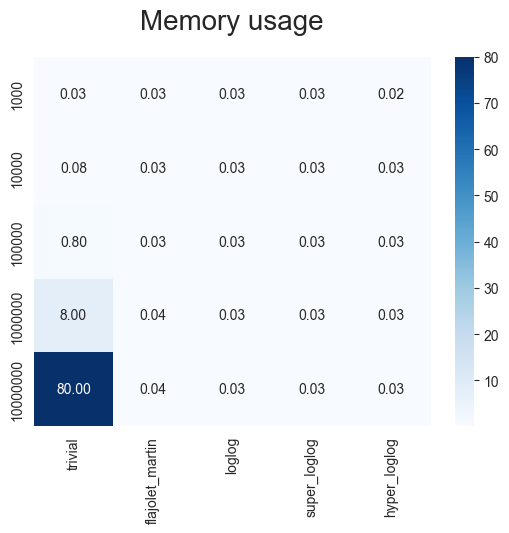

In [29]:
from multiprocessing import freeze_support
import tracemalloc
MB_IN_BYTES = 10**6
freeze_support()

memory_usages = pd.DataFrame(columns=['trivial', 'flajolet_martin', 'loglog', 'super_loglog', 'hyper_loglog'], dtype=float)

for size in sizes:
    poisson = np.random.poisson(1000, size=size)

    tracemalloc.start()

    count_trivial(poisson)
    count_flajolet_martin(poisson)
    count_loglog(poisson)
    count_super_loglog(poisson)
    count_hyper_loglog(poisson)

    statistics = tracemalloc.take_snapshot().statistics('lineno')

    memory_usages.loc[size] = [
        statistics[0].size / MB_IN_BYTES,
        statistics[1].size / MB_IN_BYTES,
        statistics[2].size / MB_IN_BYTES,
        statistics[3].size / MB_IN_BYTES,
        statistics[4].size / MB_IN_BYTES,
    ]

plt.title("Memory usage", fontsize=20, pad=20)
sns.heatmap(memory_usages, annot=True, fmt='.2f', cmap='Blues')
plt.show()

Here we come to the real purpose of these algorithms. They allow you to determine the number of unique elements for a constant memory, which depends only on the desired accuracy. The trivial algorithm, on the other hand, directly depends on the size of the input data, which is clearly visible in the table.

Using these algorithms, we managed to reduce the memory usage by almost 3 thousand times on an input data size equal to 10 million.